In [81]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct  4 17:57:07 2025

@author: coletamburri
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib as mpl
import tol_colors
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.io import readsav
import astropy.units as u
from astropy.coordinates import SpectralCoord
import astropy


def normalize(arr):
    norm_arr = []
    minimum = np.nanmin(arr)
    maximum = np.nanmax(arr)
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr

def normalize_range(arr,lowlim=0,highlim=-1):
    norm_arr = []
    minimum = np.nanmin(arr[lowlim:highlim])
    maximum = np.nanmax(arr[lowlim:highlim])
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr    

c=2.99e5
lamb2 = 486.1
mu1 = 0.4760111410077789
mu2 = 0.4266927415494022
mu3=.54
muhead = 1

#ViSP instrument
fwhm = .003 # in nm # 0.003 is from the convolution and comparison to atlas, 
            #but 0.01 makes RADYN/DKIST match a lot better? extra gaussian impact somewhere?
            # 0.001 to preserve shape of Hbeta in care for deep heating...
flagh20 = 1
flagh20sum = 0

#only one of the following should be 1
flagb = 0
flagvt = 0
flagt = 0

hbetawl=486.135
lamb0=486.135
hbeta_low = 422
hbeta_high = 706



lowvisp=148
highvisp=148+91
#lowvisp=0
#highvisp=-1

def veltrans(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def veltrans2(x,mu):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian(x, c1, mu1, sigma1):
    res = c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

def gaussfit(params,selwl,sel):
    fit = gaussian( selwl, params )
    return (fit - sel)

def double_gaussian( x, c1, mu1, sigma1, c2, mu2, sigma2 ):
    res =   (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )) \
          + (c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    return res

def tocgs(self, w, s):
    clight=2.99792458e10         #speed of light [cm/s]
    joule_2_erg=1e7
    aa_to_cm=1e-8
    s *=joule_2_erg/aa_to_cm # from Watt /(cm2 ster AA) to erg/(s cm2 ster cm)
    s *=(w*aa_to_cm)**2/clight   # to erg/
    return s

def tosi(self, wav, s):
    clight=2.99792458e8      #speed of light [m/s]                                  
    aa_to_m=1e-10                                                                        
    cm_to_m=1e-2                       
    s /= cm_to_m**2 * aa_to_m # from from Watt /(s cm2 ster AA) to Watt/(s m2 ster m) 
    s *= (wav*aa_to_m)**2 / clight # to Watt/(s m2 Hz ster)
    return s

#example convolution with gaussian psf
def gaussian_psf(x, fwhm):
	#x = wavelength [nm]
	# fwhm in [nm]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr

#write adjustment for point spread function from atlas
def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range):
   
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    #dw=new_dispersion_range[1]-new_dispersion_range[0]
    #dw=dw
    #tw=(np.arange(ntw)-ntw//2)*dw
    
    stddev_pixels = fwhm/(new_dispersion_range[1]-new_dispersion_range[0])
    gaussian_kernel = Gaussian1DKernel(stddev=stddev_pixels)
   	
    #psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    #yconv = convolve(yatlas, psf, mode='same', method='fft')
    yconv = convolve(yatlas,gaussian_kernel)
    
    return yconv

def doppler_shift_to_wavelength(observed_wavelength, velocity):
    """
    Converts observed wavelength to rest wavelength using the Doppler shift formula.

    Parameters:
        observed_wavelength: The observed wavelength in Angstroms (u.AA)
        velocity: The velocity of the object in km/s (u.km/s)

    Returns:
        rest_wavelength: The rest wavelength in Angstroms (u.nm)
    """

    observed_wavelength = observed_wavelength * u.nm
    velocity = velocity * u.km / u.second

    rest_wavelength = (observed_wavelength / (1 + velocity / astropy.constants.c)) - observed_wavelength

    return rest_wavelength.to(u.nm)

In [99]:
#define models to compare
base = '/Users/coletamburri/Desktop/RH_Versions_and_Tools/RH_output_files_npz/'
modelnameqs = '11Aug_Cclass_A_final_0s_mu1.npz' #same for all
#modelnameqs05 = '11Aug_Cclass_A_final_0s_mu0.5.npz' #same for all
#modelnameqs0 = 'rhf1d_11Aug_Cclass_A_final_0s_mu0.npz' #same for all



feature = 'deepheating' #red or deepheating or symmetric or blueshift
models = []
# for redshift figure
if feature == 'red':
    models.append('11Aug_Cclass_D_final_22s_mu1.npz') #region D, 22s (time-consistent; small redshift)
    models.append('11Aug_Cclass_A_final_7s_mu1.npz') #region AB, 7s (big redshift)
    models.append('rhf1d_11Aug_Cclass_TC_8s_mu1.npz') # region D, TC, 8s (some redshift)
    models.append('rhf1d_11Aug_Cclass_EB+TC_8s_mu1.npz') # region D, EB+TC, 8s (more redshift than TC
elif feature == 'deepheating':
    models.append('11Aug_Cclass_deepheating_12s_mu1.npz') #deepheating, 12s 
    models.append('rhf1d_11Aug_Cclass_deepheating_12s_mu0.npz')# also deepheating at 12s with mu close to 0?
elif feature == 'symmetric':
    models.append('11Aug_Cclass_A_final_36s_7vt_mu1.npz') #time-consistent model for region AB
    models.append('11Aug_Cclass_A_final_36s_7vt_mu0.5.npz')#same but at mu=0.5
    models.append('11Aug_Cclass_A_final_36s_nonuniform_mu0.5.npz') #first attempt at nonuniform vt, mu=0.5
elif feature == 'blueshift':
    models.append('rhf1d_11Aug_Cclass_D_proton_35s_mu1.npz') # proton beam at 35 post-RH
    models.append('11Aug_Cclass_regionD_proton_21s_mu1.npz') # proton beam at 21 post-RH
    models.append('rhf1d_11Aug_Cclass_gentleevap_13s_mu1.npz') # gentle evaporation at 13 s post-RH
    RADYNonly_proton = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_Cclass_d_proton_v2.sav'
    RADYNonly_ge = '/Users/coletamburri/Desktop/RADYN_Runs_SCPed/11Aug2024_alternative_heating/11Aug2024_gentleevaptake2.sav'
    


# put pixels of note here

if feature == 'red':
    cc=[[62,1483],
        [62,1470],
        [60,1483],
        [60,1475]]
        
if feature == 'deepheating':
    cc=[[75,1436],
        [72,1436],
        [75,1450]]

if feature == 'symmetric':
    cc=[[80,1090],
        [75,1110],
        [82,1140]]

if feature == 'blueshift':
    cc=[[68,780],
        [75,760],
        [65,760]]

In [83]:
#load DKIST spectra
dkist_file = '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSP_spectra_processed_11Aug24_Hbeta.npz'
dkist_file = np.load(dkist_file)

dkist_wl = dkist_file['wl']
dkist_int = dkist_file['flare']
dkist_avg = np.mean(dkist_int[lowvisp:highvisp,hbeta_low:hbeta_high,:],1)
dkist_blue = dkist_int[lowvisp:highvisp,hbeta_low+20,:]

dkist_time = dkist_file['time']

In [85]:
dkist_blue = dkist_int[lowvisp:highvisp,hbeta_low+30,:]


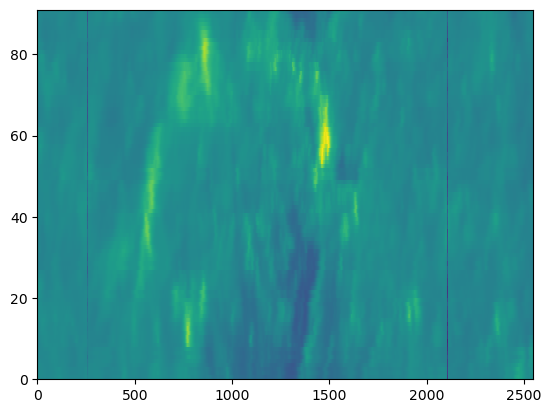

In [100]:
plt.pcolormesh(dkist_avg)

In [101]:
dkist_file

NpzFile '/Users/coletamburri/Desktop/11_Aug_2024_Cclass_Flare/Processed_ViSP_VBI_11Aug2024/ViSP_spectra_processed_11Aug24_Hbeta.npz' with keys: time, flare, wl

/var/folders/_1/p_v_pt7912z2pqq5nrvwvhlc0000gn/T/ipykernel_51076/2354387878.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


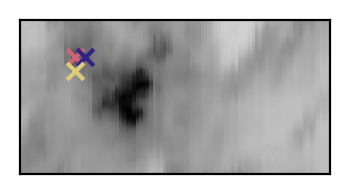

In [102]:


if feature=='red':

    choice_is = [2,3] #see notebook on 11/24 for points
    colors=tol_colors.tol_cset('muted')[4:7]
    
    
    fig,ax2=plt.subplots(dpi=200,figsize=(2,1))
    ax2.pcolormesh(np.transpose(dkist_avg),cmap='Greys') #Reds if redshifts, Blues if Deepheating, greys if symmetric
    for i in range(len(choice_is)):
        ax2.scatter(int(cc[choice_is[i]][0]),int(cc[choice_is[i]][1]),marker='x',c=colors[i])
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    
    ax2.set_ylim([1550,1400])
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig.show()
elif feature=='symmetric':
    choice_is = [0,1] #see notebook on 11/24 for points
    colors=tol_colors.tol_cset('muted')
    
    
    fig,ax2=plt.subplots(dpi=200,figsize=(2,1))
    ax2.pcolormesh(np.transpose(dkist_avg),cmap='Greys') #Reds if redshifts, Blues if Deepheating, greys if symmetric
    for i in range(len(choice_is)):
        ax2.scatter(int(cc[choice_is[i]][0]),int(cc[choice_is[i]][1]),marker='x',c=colors[i])
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    
    ax2.set_ylim([1200,1000])
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig.show()
elif feature=='deepheating':
    choice_is = [0,1,2] #see notebook on 11/24 for points
    colors=tol_colors.tol_cset('muted')
    
    
    fig,ax2=plt.subplots(dpi=200,figsize=(2,1))
    ax2.pcolormesh(np.transpose(dkist_avg),cmap='Greys') #Reds if redshifts, Blues if Deepheating, greys if symmetric
    for i in range(len(choice_is)):
        ax2.scatter(int(cc[choice_is[i]][0]),int(cc[choice_is[i]][1]),marker='x',c=colors[i])
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    
    ax2.set_ylim([1550,1400])
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig.show()

elif feature=='blueshift':
    choice_is = [0,1,2] #see notebook on 11/24 for points
    colors=tol_colors.tol_cset('muted')
    
    
    fig,ax2=plt.subplots(dpi=200,figsize=(2,1))
    ax2.pcolormesh(np.transpose(dkist_avg),cmap='Greys') #Reds if redshifts, Blues if Deepheating, greys if symmetric
    for i in range(len(choice_is)):
        ax2.scatter(int(cc[choice_is[i]][0]),int(cc[choice_is[i]][1]),marker='x',c=colors[i])
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    
    ax2.set_ylim([900,700])
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig.show()

In [103]:
if feature=='symmetric':
    choice_is = [2,3] #see notebook on 11/24 for points
    colors=tol_colors.tol_cset('muted')[4:6]
    
    
    fig,ax2=plt.subplots(dpi=200,figsize=(2,5))
    ax2.pcolormesh(np.transpose(dkist_avg),cmap='Greys') #Reds if redshifts, Blues if Deepheating, greys if symmetric
    ax2.invert_xaxis()
    ax2.invert_yaxis()



    # ax2.scatter(82,1140,marker='x',c=colors[i])


    ax2.set_ylim([1600,400])
   
    fig.show()
if feature=='blueshift':
    choice_is = [2,3] #see notebook on 11/24 for points
    colors=tol_colors.tol_cset('muted')[4:6]
    
    
    fig,ax2=plt.subplots(dpi=200,figsize=(2,5))
    ax2.pcolormesh(np.transpose(dkist_avg),cmap='Greys') #Reds if redshifts, Blues if Deepheating, greys if symmetric
    ax2.invert_xaxis()
    ax2.invert_yaxis()



    ax2.scatter(68,780,marker='x',c=colors[i])

    ax2.scatter(75,760,marker='x',c=colors[i])
    ax2.scatter(65,760,marker='x',c=colors[i])





    ax2.set_ylim([1400,400])
    ax2.set_xticks([])
    ax2.set_yticks([])
    fig.show()

In [104]:
[80,1090],
        [75,1110],
        [82,1140]]

IndentationError: unexpected indent (237088771.py, line 2)

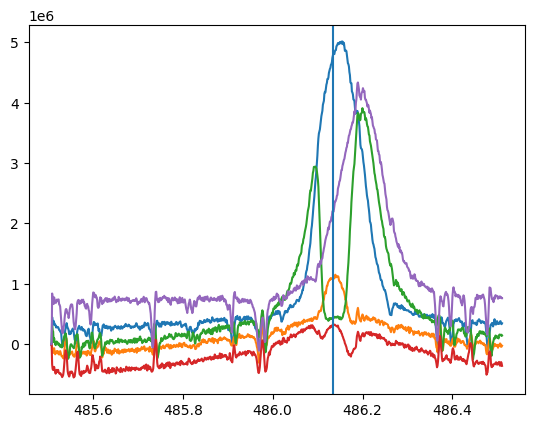

In [105]:
fig,ax=plt.subplots()
ax.plot(dkist_wl,dkist_int[lowvisp+80,:,860])
ax.plot(dkist_wl,dkist_int[lowvisp+75,:,1110])
ax.plot(dkist_wl,dkist_int[lowvisp+75,:,1436])
ax.plot(dkist_wl,dkist_int[lowvisp+20,:,1200])
ax.plot(dkist_wl,dkist_int[lowvisp+62,:,1483])








ax.axvline(486.135)

In [106]:
model_choiceqs = np.load(base+modelnameqs)
hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))

#define quiet sun stuff
model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
model_choiceqs_wlshift = model_choiceqs_wl-lamb0

dkist_wl_shift = dkist_wl-lamb0

yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)

In [107]:
modelscomp = []
for i in range(len(models)):
    selected = models[i]
    model_choice1 = np.load(base+selected)
    hbeta_indsh20 = np.where((model_choice1['wl_rh']>485.95) & (model_choice1['wl_rh']< 486.5))

    model_choice1_wl = model_choice1['wl_rh'][hbeta_indsh20]
    model_choice1_int = model_choice1['int_rh'][hbeta_indsh20]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
    
    yconv1=psf_adjust(model1_copy_wl,model1_copy_int,fwhm,dkist_wl)

    # if feature=='deepheating' and i==1:
    #     model_choiceqs = np.load(base+modelnameqs0)
    #     hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))
        
    #     #define quiet sun stuff
    #     model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
    #     model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
    #     model_choiceqs_wlshift = model_choiceqs_wl-lamb0
        
    #     dkist_wl_shift = dkist_wl-lamb0
        
    #     yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
    
    # # if feature=='symmetric' and i==1 or feature=='symmetric' and i==2:
    # #     model_choiceqs = np.load(base+modelnameqs05)
    # #     hbetainds = np.where((model_choiceqs['wl_rh']>485.95) & (model_choiceqs['wl_rh']< 486.5))
        
    # #     #define quiet sun stuff
    # #     model_choiceqs_wl = model_choiceqs['wl_rh'][hbetainds]
    # #     model_choiceqs_int = model_choiceqs['int_rh'][hbetainds]
    # #     model_choiceqs_wlshift = model_choiceqs_wl-lamb0
        
    # #     dkist_wl_shift = dkist_wl-lamb0
        
    # #     yconvqs = psf_adjust(model_choiceqs_wl,model_choiceqs_int,fwhm,dkist_wl)
        
    model_subtract1 = yconv1-yconvqs

    modelscomp.append(model_subtract1)

# for blueshift; load RADYN-only spectra
if feature=='blueshift':
    RADYN_pb = readsav(RADYNonly_proton)
    RADYN_ge = readsav(RADYNonly_ge)

    # for proton beam run
    q_pb = RADYN_pb['q']
    nq_pb = RADYN_pb['nq']
    qnorm_pb= RADYN_pb['qnorm']
    outintt_pb = RADYN_pb['outintt']
    nmu_pb = 5

    # for ge beam run
    q_ge = RADYN_ge['q']
    nq_ge = RADYN_ge['nq']
    qnorm_ge= RADYN_ge['qnorm']
    outintt_ge = RADYN_ge['outintt']
    nmu_ge = 5

    headon_hbeta_pb = outintt_pb[70,16,4,1:nq_pb[16]]-outintt_pb[0,16,4,1:nq_pb[16]]
    headon_hbeta_pb2 = outintt_pb[52,16,4,1:nq_pb[16]]-outintt_pb[0,16,4,1:nq_pb[16]]

    headon_hbeta_ge = outintt_ge[26,16,4,1:nq_ge[16]]-outintt_ge[0,16,4,1:nq_ge[16]]

    kr=16
    
    wavelengths = (doppler_shift_to_wavelength(486.135,q_pb[kr,:-1]*qnorm_pb))[0:100].value+486.135

    hbeta_inds_RADYN = np.where((wavelengths>485.95) & (wavelengths< 486.5))

    # psf adjust, for PB
    model_choice1_wl = wavelengths[hbeta_inds_RADYN]
    model_choice1_int = headon_hbeta_pb[hbeta_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)

    modelscomp.append(yconv1)

    # psf adjust, for PB2
    model_choice1_wl = wavelengths[hbeta_inds_RADYN]
    model_choice1_int = headon_hbeta_pb2[hbeta_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)

    modelscomp.append(yconv1)
    
    # psf adjust, for GE
    model_choice1_wl = wavelengths[hbeta_inds_RADYN]
    model_choice1_int = headon_hbeta_ge[hbeta_inds_RADYN]
    model_choice1_wlshift = model_choice1_wl-lamb0

    model1_copy_int = model_choice1_int
    model1_copy_wl = model_choice1_wl
    
    yconv1=psf_adjust(model_choice1_wl,model1_copy_int,fwhm,dkist_wl)
    
    modelscomp.append(yconv1)

    
    

Text(0.5, 0, 'Wavelength [nm]')

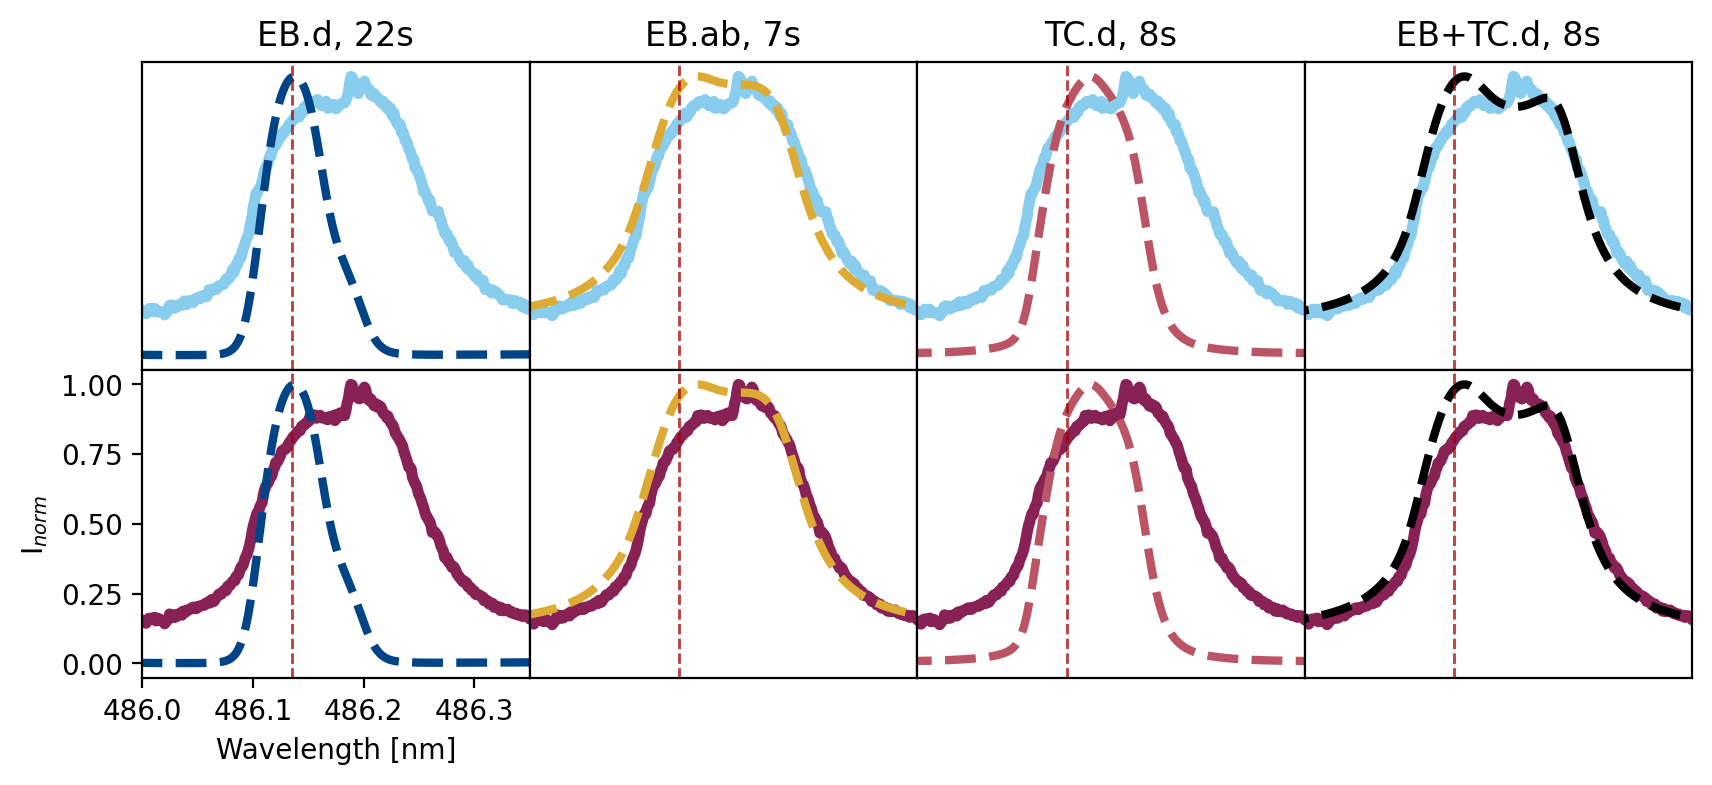

In [14]:
#for redshifts

npoints = 9
choice_is = [2,3]

#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')[4:6]

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--']
fig,ax=plt.subplots(2,4,dpi=200,figsize=(10,4))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])]),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([486.0,486.35])

        if j!=0 or i!=1:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(486.135,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

        ax[i,j].axvline(486.135,c='red',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('EB.d, 22s')
ax[0,1].set_title('EB.ab, 7s') 
ax[0,2].set_title('TC.d, 8s')
ax[0,3].set_title('EB+TC.d, 8s')

fig.subplots_adjust(hspace=0, wspace=0)

ax[1,0].set_ylabel(r'I$_{norm}$')
ax[1,0].set_xlabel('Wavelength [nm]')

Text(0.5, 0, 'Wavelength [nm]')

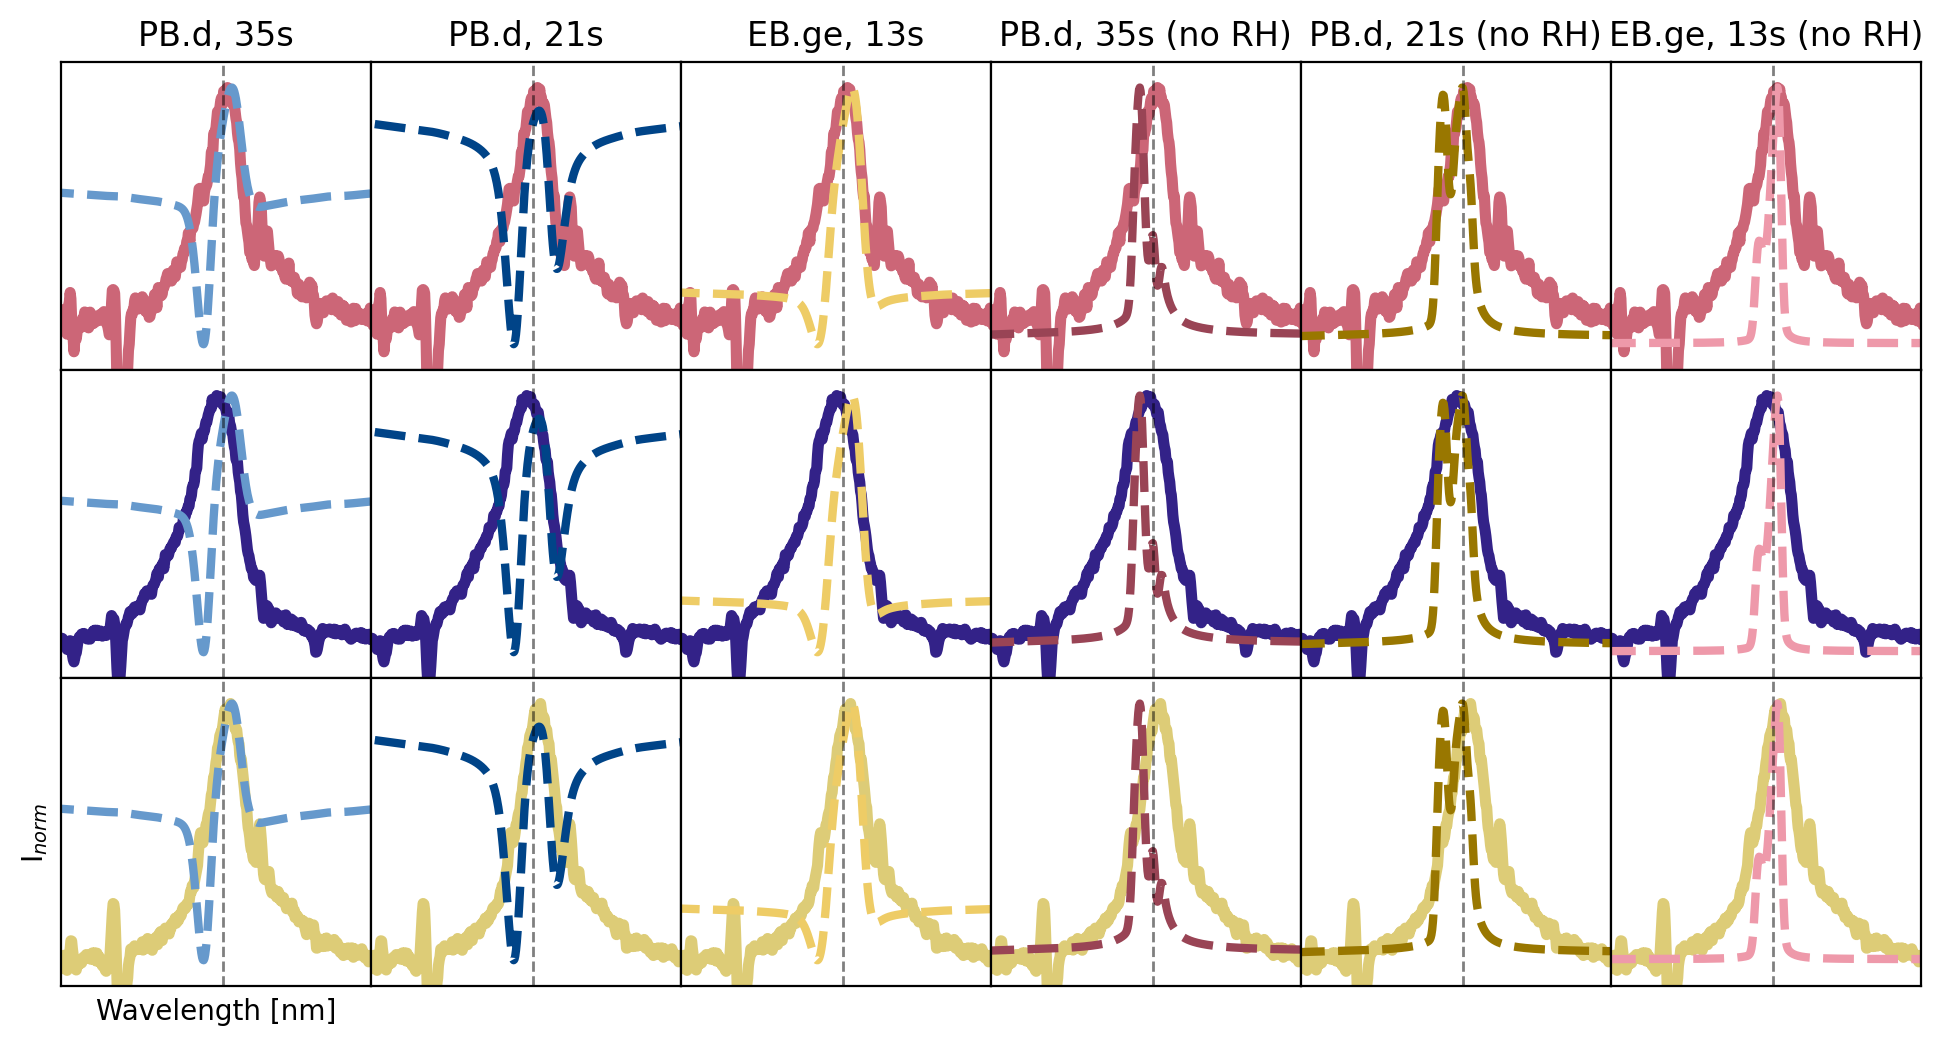

In [49]:
#for blueshifts

npoints = 9
choice_is = [0,1,2]

#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('medium-contrast')

modstyles = ['--','--','--','--','--','--']
fig,ax=plt.subplots(3,6,dpi=200,figsize=(12,6))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low+20,highlim=hbeta_high),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([485.9,486.35])
        ax[i,j].set_ylim([-0.1,1.1])
        if i!=4 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(486.135,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('PB.d, 35s')
ax[0,1].set_title('PB.d, 21s')
ax[0,2].set_title('EB.ge, 13s')
ax[0,3].set_title('PB.d, 35s (no RH)')
ax[0,4].set_title('PB.d, 21s (no RH)')
ax[0,5].set_title('EB.ge, 13s (no RH)')

fig.subplots_adjust(hspace=0, wspace=0)

ax[2,0].set_ylabel(r'I$_{norm}$')
ax[2,0].set_xlabel('Wavelength [nm]')

Text(0.5, 0, 'Wavelength [nm]')

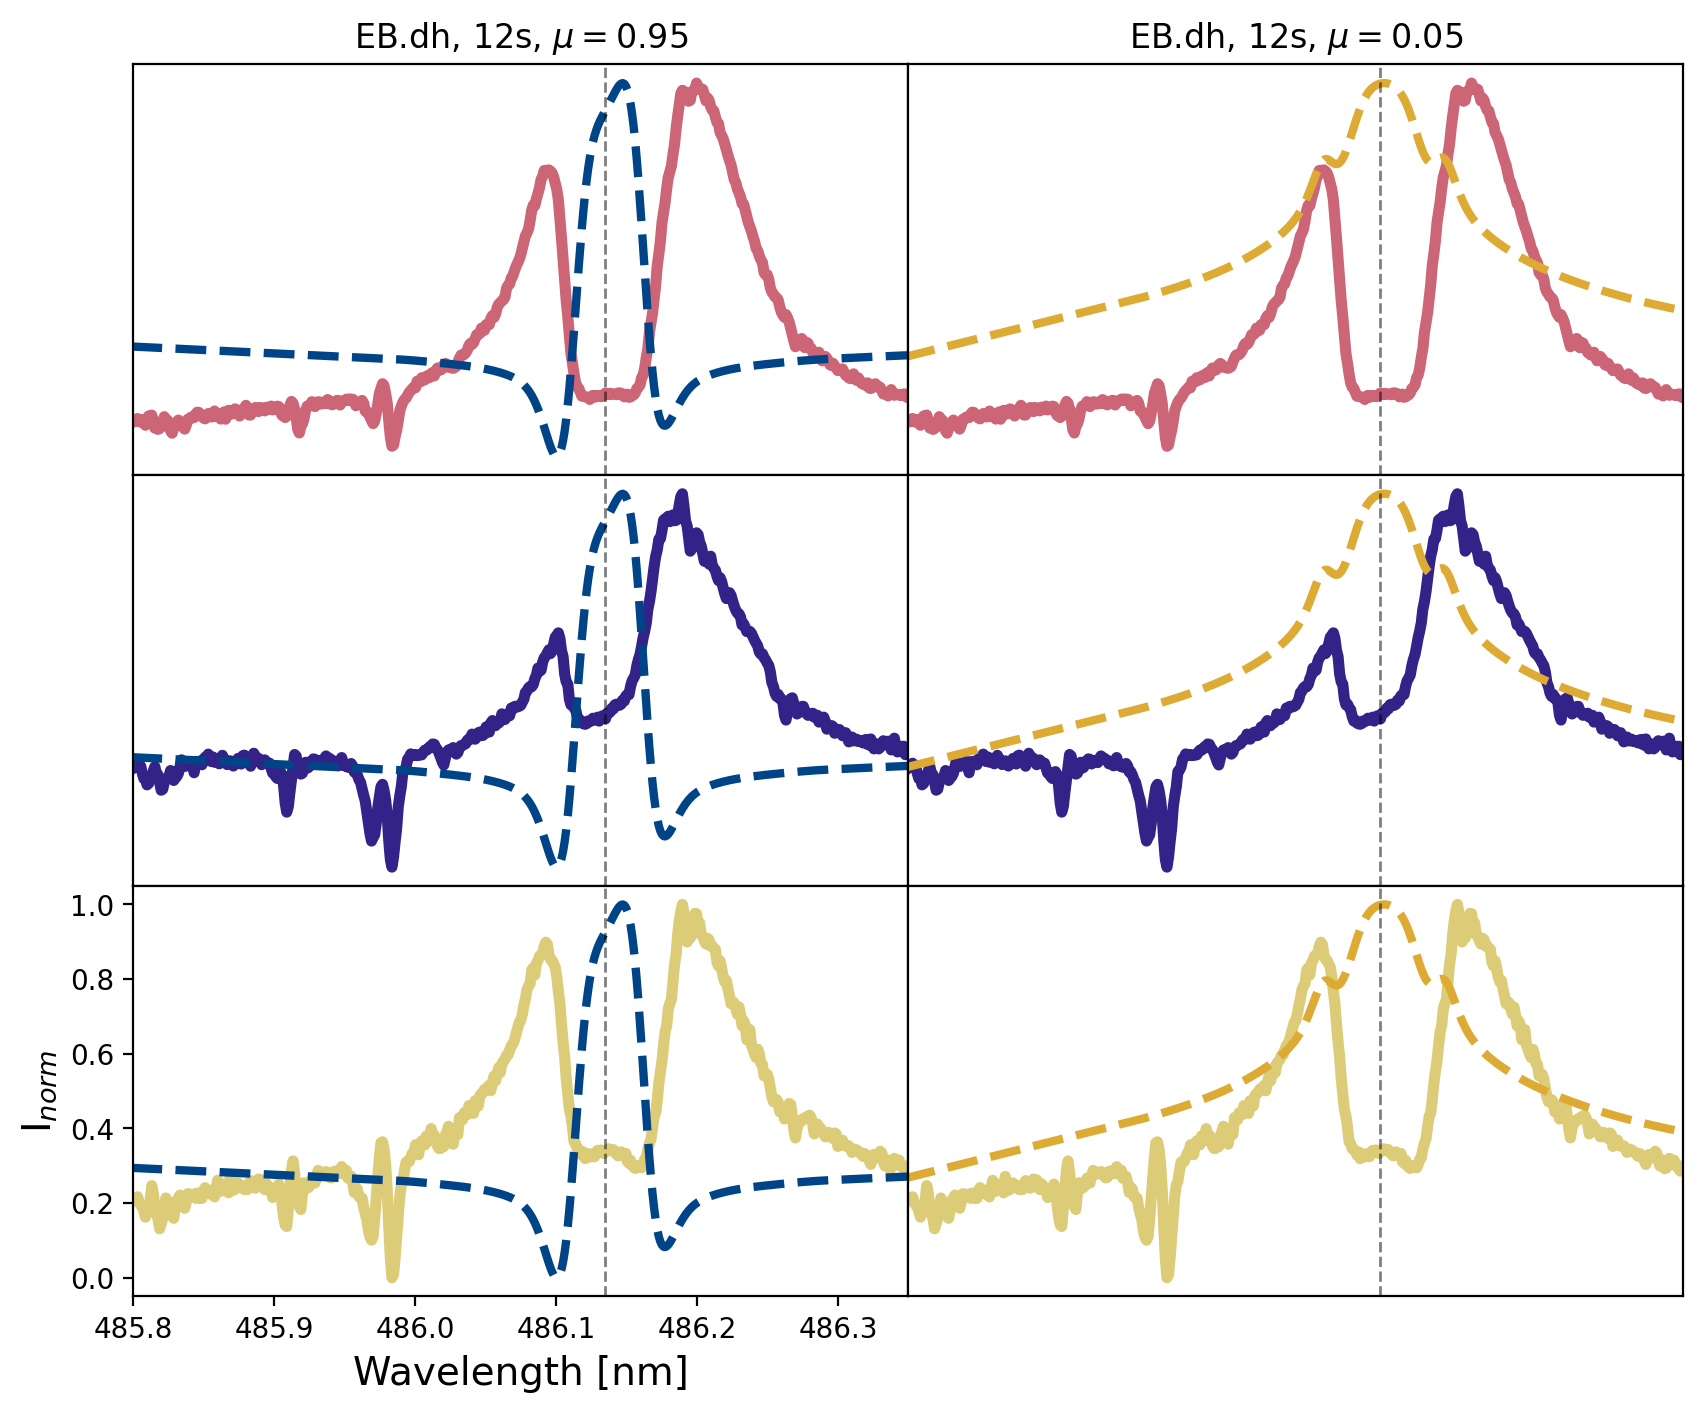

In [108]:
#for deepheating

npoints = 3
choice_is = [0,1,2]

#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--','--']
fig,ax=plt.subplots(3,2,dpi=200,figsize=(10,8))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([485.8,486.35])

        if i!=2 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        

        ax[i,j].axvline(486.135,c='black',linestyle='dashed',linewidth=1,alpha=0.5)


ax[0,0].set_title('EB.dh, 12s, $\mu=0.95$')
ax[0,1].set_title('EB.dh, 12s, $\mu=0.05$')


fig.subplots_adjust(hspace=0, wspace=0)

ax[2,0].set_ylabel(r'I$_{norm}$',fontsize=14)
ax[2,0].set_xlabel('Wavelength [nm]',fontsize=14)

#ax[2,0].set_xticks([396.8,396.9,397.0])
#ax[2,0].set_yticks([0,0.5,1])

Text(0.5, 0, 'Wavelength [nm]')

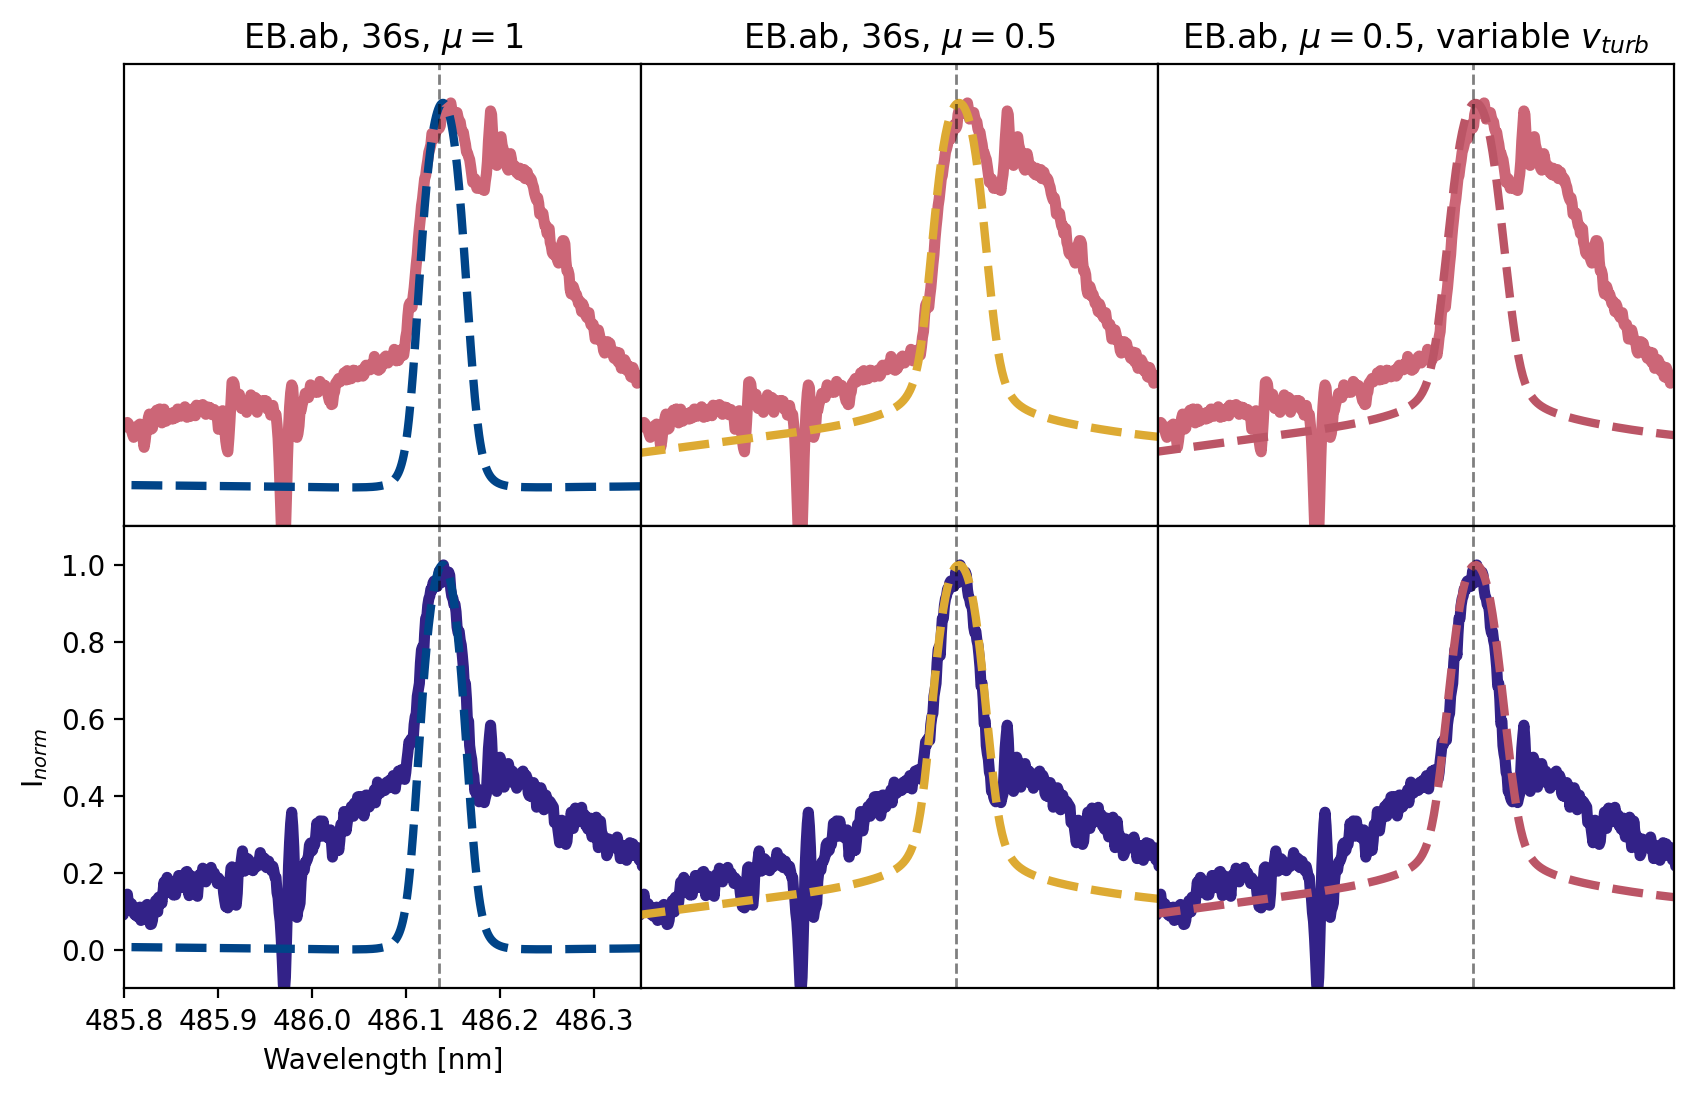

In [93]:
#for symmmetric

npoints = 9
choice_is = [0,1]

#colors = plt.cm.jet(np.linspace(0,1,len(choice_is)))
colors=tol_colors.tol_cset('muted')

modcolors=tol_colors.tol_cset('high-contrast')

modstyles = ['--','--','--']
fig,ax=plt.subplots(2,3,dpi=200,figsize=(10,6))
for i in range(len(choice_is)):
    for j in range(len(modelscomp)):
        ax[i,j].plot(dkist_wl,normalize_range(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])],lowlim=hbeta_low),alpha=1,linewidth=4,c=colors[i])
        ax[i,j].plot(dkist_wl,normalize_range(modelscomp[j]),linewidth=3,color=modcolors[j],linestyle=modstyles[j])
        ax[i,j].set_xlim([485.8,486.35])
        ax[i,j].set_ylim([-0.1,1.1])
        if i!=1 or j!=0:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

        ax[i,j].axvline(486.135,c='black',linestyle='dashed',linewidth=1,alpha=0.5)

ax[0,0].set_title('EB.ab, 36s, $\mu=1$')
ax[0,1].set_title('EB.ab, 36s, $\mu=0.5$')
ax[0,2].set_title('EB.ab, $\mu=0.5$, variable $v_{turb}$')


fig.subplots_adjust(hspace=0, wspace=0)

ax[1,0].set_ylabel(r'I$_{norm}$')
ax[1,0].set_xlabel('Wavelength [nm]')

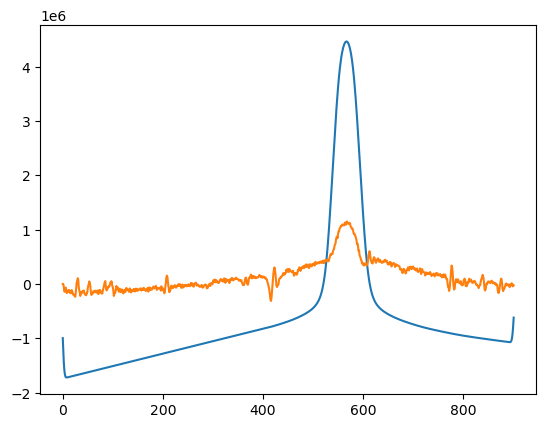

In [98]:
plt.plot(modelscomp[j])
plt.plot(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])])

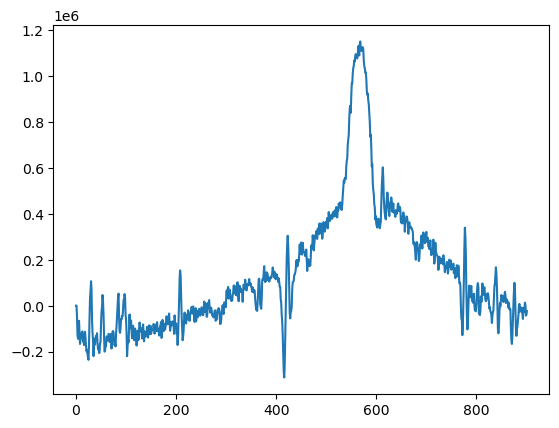

In [97]:
plt.plot(dkist_int[lowvisp+int(cc[choice_is[i]][0]),:,int(cc[choice_is[i]][1])])